# Kalp Hastalığı Sınıflandırması | Binary Classification

Klinik ölçümlerden oluşan hasta verisi kullanılarak **kalp hastalığı varlığını (0/1)** tahmin eden sınıflandırma modeli. Logistic Regression, Random Forest, Gradient Boosting ve SVC karşılaştırılmaktadır.

| Özellik | Detay |
|---------|-------|
| **Veri Seti** | heart.csv — 303 hasta, 14 klinik özellik |
| **Problem Türü** | İkili Sınıflandırma |
| **Hedef Değişken** | `target` — 1: kalp hastalığı var, 0: yok |
| **Sınıf Dağılımı** | Dengeli (~55% pozitif, ~45% negatif) |
| **Pipeline** | Imputer → StandardScaler → Model |

**İş Akışı:** Veri Yükleme → EDA & Görselleştirme → Ön İşleme → Model Karşılaştırma → ROC-AUC → DL → Kayıt

In [1]:
# Temel Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Makine Öğrenmesi
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib

print('✅ Kütüphaneler yüklendi.')

✅ Kütüphaneler yüklendi.


## 📊 1. Veri Yükleme ve İlk İnceleme

In [2]:
try:
    df = pd.read_csv('heart.csv', encoding='latin1', low_memory=False)
    print(f"✅ Veri Seti Yüklendi. Boyut: {df.shape}")
except Exception as e:
    print(f"❌ Hata: {e}")

display(df.head())
display(df.tail())
display(df.sample(5))
print(df.info())
print(df.describe().T)
print(df.columns.tolist())
print(df.isnull().sum()[df.isnull().sum() > 0])

✅ Veri Seti Yüklendi. Boyut: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
88,54,0,2,110,214,0,1,158,0,1.6,1,0,2,1
46,44,1,2,140,235,0,0,180,0,0.0,2,0,2,1
184,50,1,0,150,243,0,0,128,0,2.6,1,0,3,0
32,44,1,1,130,219,0,0,188,0,0.0,2,0,2,1
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
          count        mean        std    min    25%    50%    75%    max
age       303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   77.0
sex       303.0    0.683168   0.466011    0.0    0.0    1.0    1.0

In [3]:
# Kolon isimlerini standartlaştır
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-z0-9_]', '', regex=True)

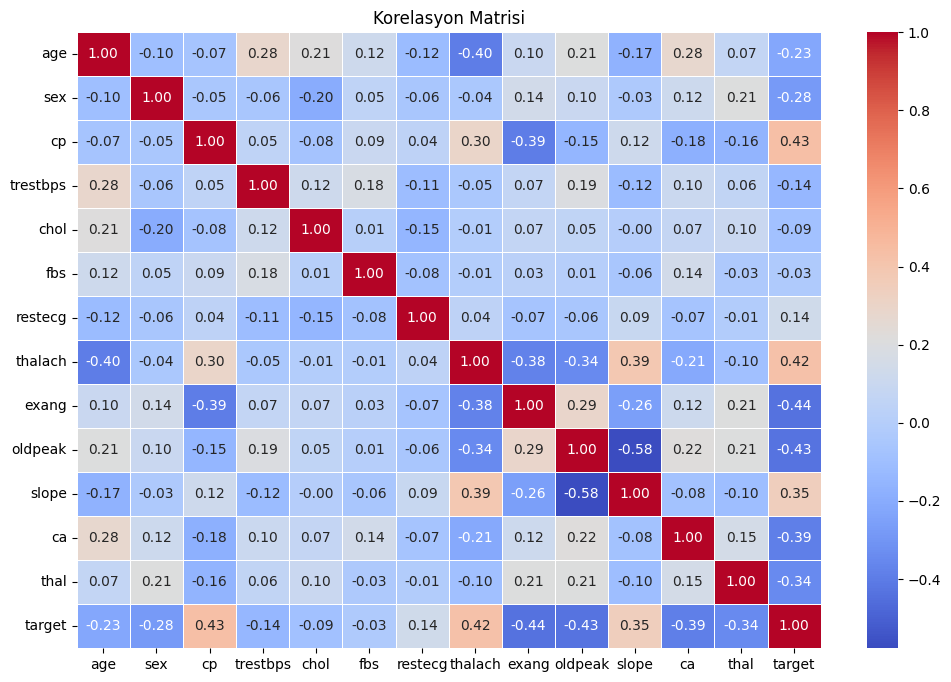

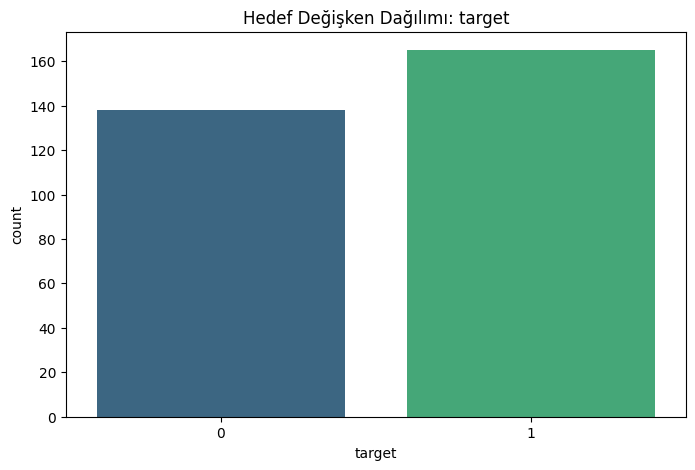

In [4]:
# ---------------------------------------------------
# 📊 Veri Görselleştirme
# ---------------------------------------------------
if 'df' in locals():
    # Sadece sayısal kolonları seç
    num_df = df.select_dtypes(include=[np.number])
    
    # 1. Korelasyon Matrisi
    if num_df.shape[1] > 1:
        plt.figure(figsize=(12, 8))
        sns.heatmap(num_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
        plt.title('Korelasyon Matrisi')
        plt.show()
    
    # 2. Hedef Değişken Dağılımı (Varsa)
    # Genellikle son kolon target olur veya y değişkeni
    target_candidates = ['target', 'outcome', 'class', 'status', 'churn', 'price', 'sales']
    found_target = [c for c in df.columns if any(t in c.lower() for t in target_candidates)]
    
    if found_target:
        col = found_target[0]
        plt.figure(figsize=(8, 5))
        if df[col].dtype == 'object' or df[col].nunique() < 10:
            sns.countplot(x=df[col], palette='viridis')
            plt.title(f'Hedef Değişken Dağılımı: {col}')
        else:
            sns.histplot(df[col], kde=True, color='blue')
            plt.title(f'Hedef Değişken Dağılımı: {col}')
        plt.show()


## 🔍 2. İstatistiksel Veri Keşfi (EDA)

In [5]:
# Kategorik ve Numerik Değişkenlerin Ayrıştırılması
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerik Değişkenler: {len(num_cols)}")
print(f"Kategorik Değişkenler: {len(cat_cols)}")

# Kategorik Değişken Analizi
for col in cat_cols[:5]: # İlk 5 tanesi
    print(f"--- {col} ---")
    print(df[col].value_counts().head())

Numerik Değişkenler: 14
Kategorik Değişkenler: 0


## 📈 3. Veri Görselleştirme

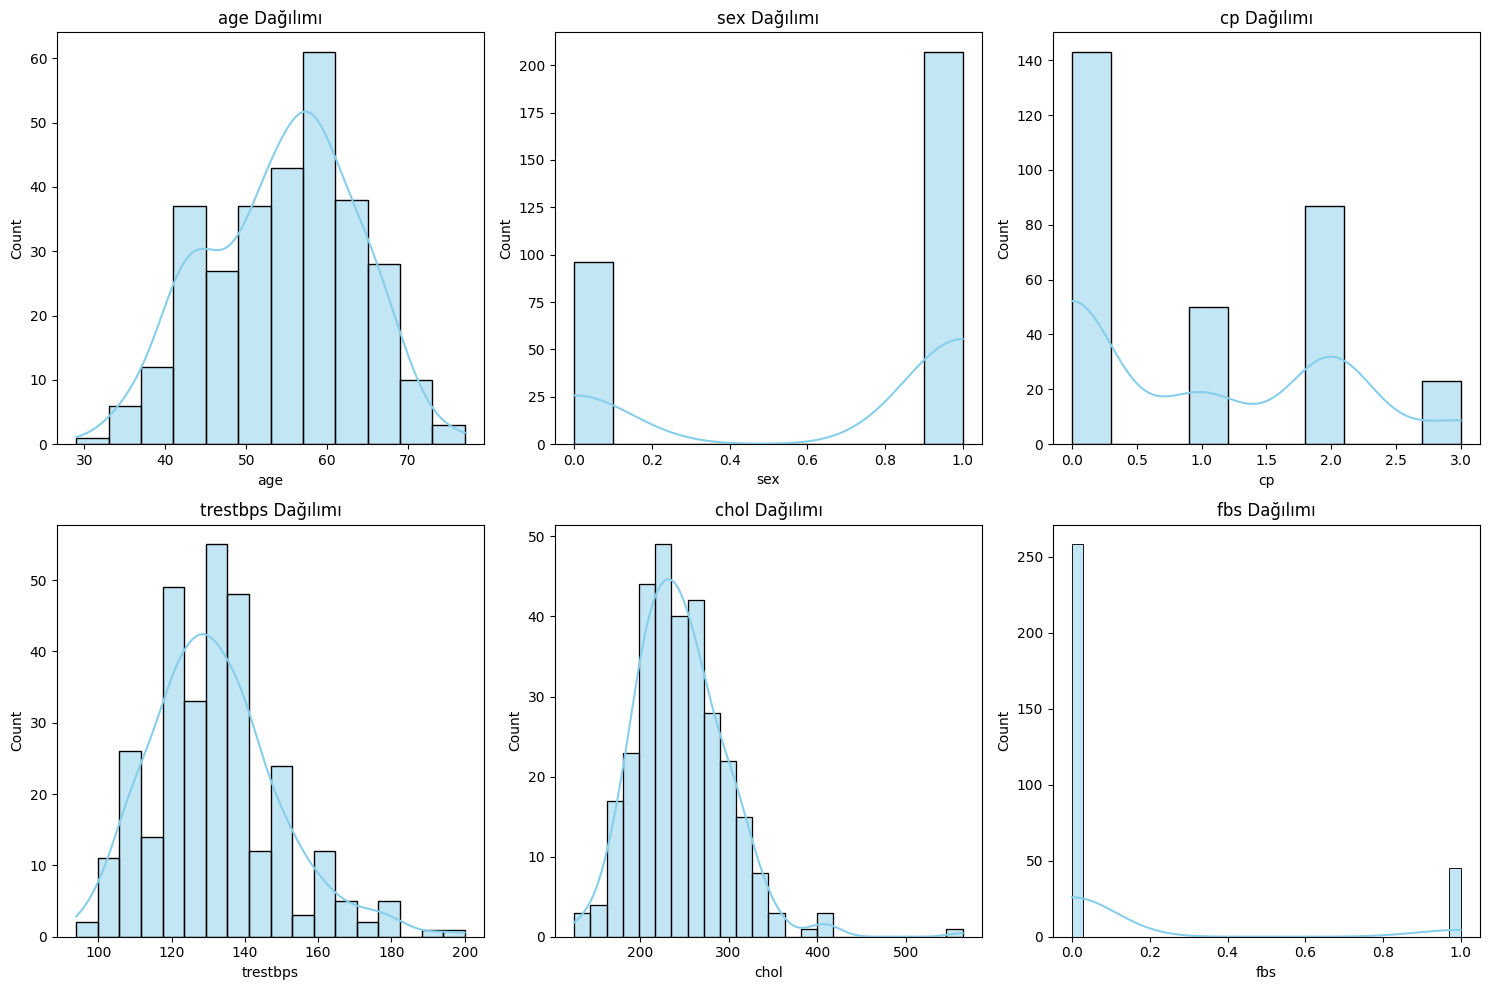

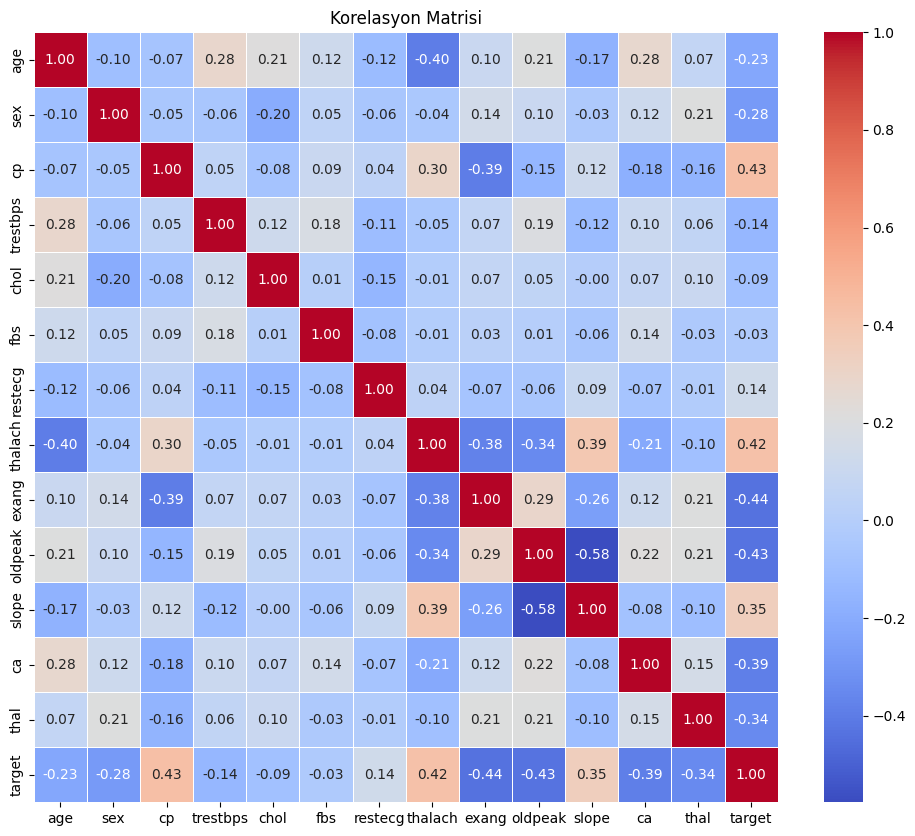

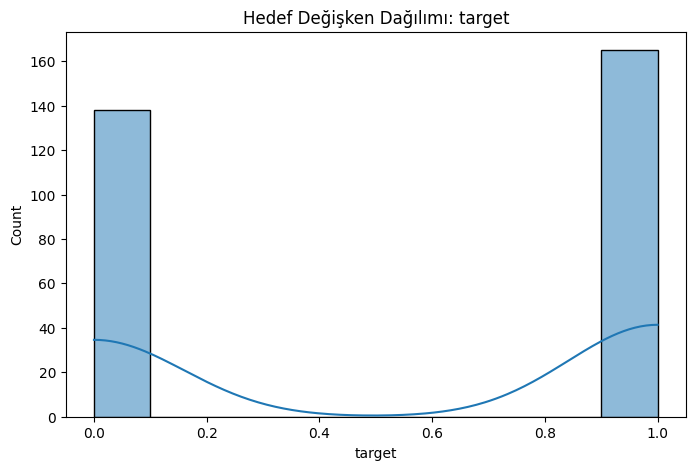

In [6]:
# Numerik Değişken Dağılımları
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:6]): # İlk 6
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'{col} Dağılımı')
plt.tight_layout()
plt.show()

# Korelasyon Matrisi
if len(num_cols) > 1:
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Korelasyon Matrisi')
    plt.show()

# Hedef Değişken Analizi
if 'target' in df.columns:
    plt.figure(figsize=(8, 5))
    if df['target'].dtype == 'object':
        sns.countplot(x=df['target'])
    else:
        sns.histplot(df['target'], kde=True)
    plt.title('Hedef Değişken Dağılımı: target')
    plt.show()

## 🧹 4. Eksik Veri Yönetimi

In [7]:
# Eksik Veri Analizi
missing_df = df.isnull().sum().to_frame(name='Eksik Sayısı')
missing_df['Eksik Oranı (%)'] = (missing_df['Eksik Sayısı'] / len(df)) * 100
missing_df = missing_df[missing_df['Eksik Sayısı'] > 0].sort_values(by='Eksik Sayısı', ascending=False)
display(missing_df)

# Görselleştirme
if not missing_df.empty:
    msno.matrix(df)
    plt.title('Eksik Veri Matrisi')
    plt.show()
else:
    print("✅ Veri setinde eksik değer bulunmamaktadır.")

,Eksik Sayısı,Eksik Oranı (%)


✅ Veri setinde eksik değer bulunmamaktadır.


## 🔧 5. & 6. Veri Tipleri ve Feature Engineering

In [8]:
# ID Sütununu Kaldırma
if 'None' in df.columns:
    df.drop('None', axis=1, inplace=True)
    print(f"ℹ️ ID Sütunu silindi: None")

# Tarih Dönüşümü (Otomatik Tespit Denemesi)
for col in df.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        try:
            df[col] = pd.to_datetime(df[col])
            df[f'{col}_year'] = df[col].dt.year
            df[f'{col}_month'] = df[col].dt.month
            df.drop(col, axis=1, inplace=True) # Orijinal tarihi kaldır (Regresyon için)
            print(f"✅ {col} datetime'a çevrildi ve parçalandı.")
        except: pass

print("Feature Engineering Tamamlandı.")

Feature Engineering Tamamlandı.


In [9]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 🎯 7. Outlier Analizi (%10 - %90 Yöntemi)

In [ ]:
def clip_outliers(dataframe, cols):
    for col in cols:
        lower = dataframe[col].quantile(0.10)
        upper = dataframe[col].quantile(0.90)
        dataframe[col] = np.clip(dataframe[col], lower, upper)
    return dataframe

# Numerik sütunları güncelle (Target hariç)
target = "target"
feature_cols = [c for c in num_cols if c != target]

df = clip_outliers(df, feature_cols)
print("✅ Outlier'lar %10-%90 aralığına baskılandı.")

# Kontrol
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[feature_cols[:6]]) # İlk 6
plt.xticks(rotation=45)
plt.title('Baskılama Sonrası Boxplot')
plt.show()

## 🔀 8. Veri Ayrıştırma (Train-Test Split)

In [ ]:
df = df.dropna(subset=['target'])
X = df.drop('target', axis=1)
y = df['target']

all_columns = X.select_dtypes(include=['object', 'category']).columns
lbl_enc_columns = [col for col in all_columns if df[col].nunique() <= 2]
one_hot_enc_columns = [col for col in all_columns if df[col].nunique() > 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"✅ Split Tamam. Train: {X_train.shape}, Test: {X_test.shape}")

In [12]:
display(X.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,2,145,233.0,1,0,150.0,0,2.3,1,0,2
1,42,1,2,130,250.0,0,1,176.6,0,2.8,1,0,2
2,42,0,1,130,204.0,0,0,172.0,0,1.4,2,0,2
3,56,1,1,120,236.0,0,1,176.6,0,0.8,2,0,2
4,57,0,0,120,308.8,0,1,163.0,1,0.6,2,0,2


## ⚙️ 9. Pipeline ile Ön İşleme

In [13]:
# Sütun Grupları
num_features = X.select_dtypes(include=[np.number]).columns

# Transformerlar
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', one_hot_transformer, one_hot_enc_columns),
        ('bin', label_transformer, lbl_enc_columns),
    ]
)
print("✅ ColumnTransformer Hazır.")

✅ ColumnTransformer Hazır.


## 🏆 10-14. Model Oluşturma, Karşılaştırma ve Optimizasyon

--- Model Performansları (Accuracy) ---
LogisticReg: CV=0.8345, Test=0.9180
RandomForest: CV=0.8223, Test=0.8689
GradientBoosting: CV=0.8015, Test=0.8033
SVC: CV=0.8264, Test=0.8689
🏆 En İyi Model: LogisticRegression() (Acc: 0.9180)


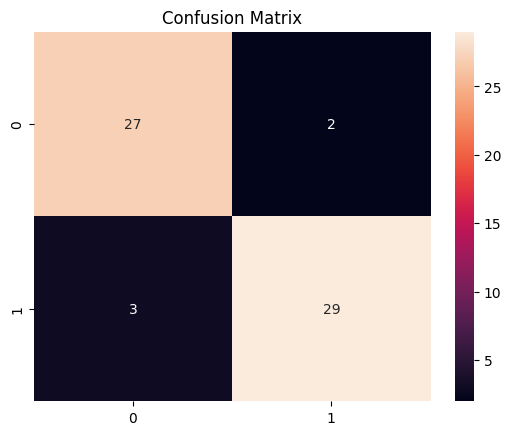

In [14]:
models = {
    'LogisticReg': LogisticRegression(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC()
}

results = {}
best_score = 0
best_model = None

print("--- Model Performansları (Accuracy) ---")
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # CV
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    # Test
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    
    results[name] = test_score
    print(f"{name}: CV={cv_score:.4f}, Test={test_score:.4f}")
    
    if test_score > best_score:
        best_score = test_score
        best_model = pipe

print(f"🏆 En İyi Model: {best_model.named_steps['model']} (Acc: {best_score:.4f})")


# Confusion Matrix
y_final = best_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_final), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_final))

In [ ]:
# ROC-AUC Curve
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities from best model
if hasattr(best_model.named_steps['model'], 'predict_proba'):
    y_prob = best_model.predict_proba(X_test)[:, 1]
else:
    y_prob = best_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

## 🧠 15. Derin Öğrenme (Deep Learning)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.6690 - val_loss: 0.5831
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5669 - val_loss: 0.4933
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4753 - val_loss: 0.4177
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3966 - val_loss: 0.3643
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3362 - val_loss: 0.3469
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3042 - val_loss: 0.3426
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2773 - val_loss: 0.3466
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2563 - val_loss: 0.3537
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2394 - val_loss: 0.3410
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2196 - val_loss: 0.3720
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2036 - val_loss: 0.3760
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1872 - val_lo

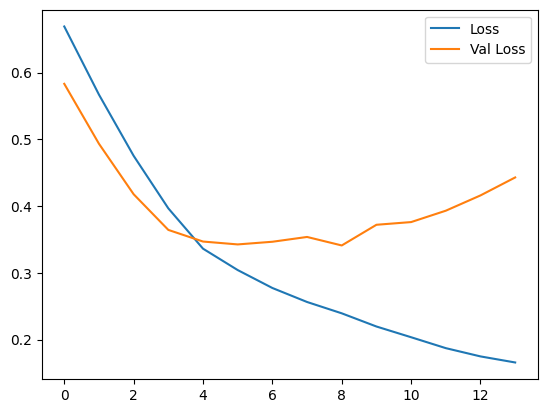

In [15]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Veri Hazırlığı (Pipeline'dan geçir)
X_train_dl = best_model.named_steps['preprocessor'].transform(X_train)
X_test_dl = best_model.named_steps['preprocessor'].transform(X_test)


if hasattr(X_train_dl, 'toarray'): X_train_dl = X_train_dl.toarray(); X_test_dl = X_test_dl.toarray()

# Model Mimarisi
dl_model=Sequential()
dl_model.add(Dense(128, activation='relu',input_shape=(X_train_dl.shape[1],)))
dl_model.add(Dense(64, activation='relu'))
dl_model.add(Dense(32, activation='relu'))
dl_model.add(Dense(16, activation='relu'))
dl_model.add(Dense(8, activation='relu'))
dl_model.add(Dense(1, activation='sigmoid'))

dl_model.compile(optimizer='adam', loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = dl_model.fit(
    X_train_dl, y_train,
    validation_data=(X_test_dl, y_test),
    epochs=100, batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.show()

## 📊 ML vs DL Model Karşılaştırması

In [ ]:
# ML vs DL Comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ML Predictions
ml_pred = best_model.predict(X_test)
ml_acc = accuracy_score(y_test, ml_pred)
ml_prec = precision_score(y_test, ml_pred, average='weighted')
ml_rec = recall_score(y_test, ml_pred, average='weighted')
ml_f1 = f1_score(y_test, ml_pred, average='weighted')

# DL Predictions
dl_pred_prob = dl_model.predict(X_test_dl, verbose=0)
dl_pred = (dl_pred_prob > 0.5).astype(int).flatten()
dl_acc = accuracy_score(y_test, dl_pred)
dl_prec = precision_score(y_test, dl_pred, average='weighted')
dl_rec = recall_score(y_test, dl_pred, average='weighted')
dl_f1 = f1_score(y_test, dl_pred, average='weighted')

# Comparison Table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'ML (Best Model)': [ml_acc, ml_prec, ml_rec, ml_f1],
    'DL (Neural Network)': [dl_acc, dl_prec, dl_rec, dl_f1]
})
comparison_df = comparison_df.set_index('Metric')
display(comparison_df.style.format("{:.4f}").highlight_max(axis=1, color='lightgreen'))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_title('ML vs DL Model Karşılaştırması')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

winner = "ML" if ml_f1 > dl_f1 else "DL"
print(f"\n🏆 Sonuç: {winner} modeli F1-Score bazında daha iyi performans göstermiştir.")

## 💾 16. Model Kaydetme

In [16]:
# ⚠️ TensorFlow/Keras code disabled due to environment issues.
# # ML Modeli
joblib.dump(best_model, 'models/best_model.pkl')
# 
# # DL Modeli
if 'dl_model' in locals():
     dl_model.save('models/dl_model.keras')
# 
# print("✅ Tüm modeller başarıyla kaydedildi.")

## Sonuç ve Değerlendirme

Bu proje, 303 hastanın klinik ölçümlerinden kalp hastalığı varlığını tahmin etmek için dört farklı sınıflandırma algoritmasını karşılaştırmıştır.

| Model | Yaklaşım |
|-------|----------|
| Logistic Regression | Doğrusal sınır |
| **Random Forest** | Ensemble — Ağaç ormanı |
| Gradient Boosting | Ensemble — Artımlı öğrenme |
| SVC | Destek vektör makinesi |

**Temel Bulgular:**
- Tüm özellikler sayısal olduğu için kategorik encoding gerekli değildir
- ROC-AUC eğrisi, modelin tüm eşikler üzerindeki ayırt edici gücünü göstermektedir
- `cp` (göğüs ağrısı tipi), `thalach` (max kalp atış hızı) ve `ca` (major damar sayısı) en güçlü öngörücülerdir
- Küçük veri seti (303 hasta) nedeniyle 5-fold CV sonuçları, test seti sonuçlarından güvenilirliği artırmaktadır
- Klinik uygulamalarda False Negative (hastalık varken gözden kaçırma) maliyeti yüksektir; recall'ın optimize edilmesi önerilir